# Понижение размерности

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = [11, 8]

## Отбор признаков

Самый простой способ выделения признаков &mdash; их отбор. Не будем сильно заострять внимание
на этом методе, так как он очень простой, просто приведем пример, показывающий, что
так можно примитивно сокращать ресурсоемкость алгоритмов.

Отберем признаки на основе их корреляции с целевым признаком, и сравним результаты с исходными.

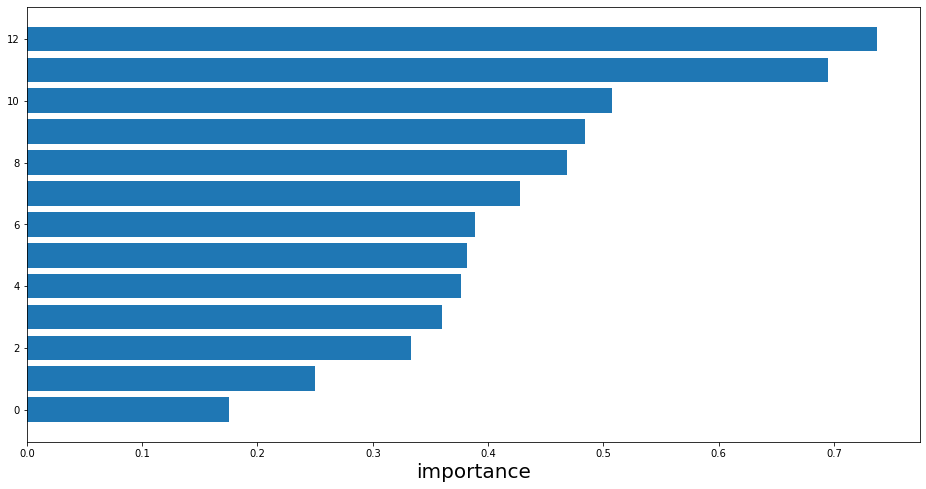

In [4]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

ds = load_boston()
X, y = ds.data, ds.target
indexes = np.arange(len(y))
np.random.seed(52342)
np.random.shuffle(indexes)
X = X[indexes, :]
y = y[indexes]

features_ind = np.arange(X.shape[1])
corrs = np.abs([pearsonr(X[:, i], y)[0] for i in features_ind])
importances_sort = np.argsort(corrs)
fig = plt.figure(figsize=(16,8))
plt.barh(features_ind, corrs[importances_sort])
plt.xlabel('importance', fontsize=20)
X = X[:, importances_sort]

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

features_counts = np.arange(X.shape[1])

def scores_by_features_count(reg):
    scores = []
    for features_part in features_counts:
        X_part = X[:,importances_sort[features_part:]]
        scores.append(cross_val_score(reg, X_part, y, cv=5).mean())
    return scores

linreg_scores = scores_by_features_count(LinearRegression())
rf_scores = scores_by_features_count(RandomForestRegressor(n_estimators=100, max_depth=3))

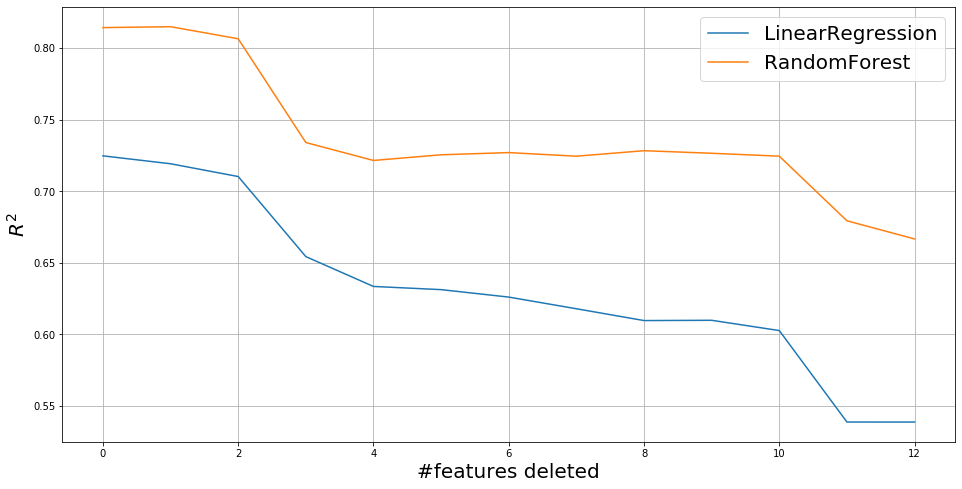

In [8]:
plt.figure(figsize=(16,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

В общем, если мы захотим немного сократить потребление ресурсов, пожертвовав частью качества,
видно, что это можно сделать.

## Метод главных компонент (Principal Component Analysis, PCA)

Выделение новых признаков путем их отбора часто дает плохие результаты, и
в некоторых ситуациях такой подход практически бесполезен. Например, если
мы работаем с изображениями, у которых признаками являются яркости пикселей,
невозможно выбрать небольшой поднабор пикселей, который дает хорошую информацию о
содержимом картинки. 

Поэтому признаки нужно как-то комбинировать. Рассмотрим метод главных компонент.

Этот метод делает два важных упрощения задачи:

1. Игнорируется целевая переменная
2. Строится линейная комбинация признаков

П. 1 на первый взгляд кажется довольно странным, но на практике обычно не является
таким уж плохим. Это связано с тем, что часто данные устроены так, что имеют какую-то
внутреннюю структуру в пространстве меньшей размерности, которая никак не связана с
целевой переменной. Поэтому и оптимальные признаки можно строить, не глядя на ответ.

П. 2 тоже сильно упрощает задачу, но далее мы научимся избавляться от него.

### Теория

Кратко вспомним, что делает этот метод (подробно см. в лекции).

Обозначим $X$ &mdash; матрица объекты-признаки, с нулевым средним каждого признака,
а $w$ &mdash; некоторый единичный вектор. Тогда
$Xw$ задает величину проекций всех объектов на этот вектор. Далее ищется вектор,
который дает наибольшую дисперсию полученных проекций (то есть наибольшую дисперсию
вдоль этого направления):

$$
    \max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w
$$

Подходящий вектор тогда равен собственному вектору матрицы $X^T X$ с наибольшим собственным
значением. После этого все пространство проецируется на ортогональное дополнение к вектору
$w$ и процесс повторяется.

### PCA на плоскости

Для начала посмотрим на метод PCA на плоскости для того, чтобы
лучше понять, как он устроен.

Попробуем специально сделать один из признаков более значимым и проверим, что PCA это обнаружит. Сгенерируем выборку из двухмерного гауссовского распределения. Обратите внимание, что выборка
изначально выбирается центрированной.

In [9]:
np.random.seed(314512)

data_synth_1 = np.random.multivariate_normal(
    mean=[0, 0], 
    cov=[[4, 0], 
         [0, 1]],
    size=1000)

Теперь изобразим точки выборки на плоскости и применим к ним PCA для нахождения главных компонент.
В результате работы PCA из sklearn в `dec.components_` будут лежать главные направления (нормированные), а в `dec.explained_variance_` &mdash; дисперсия, которую объясняет каждая компонента. Изобразим на нашем графике эти направления, умножив их на дисперсию для наглядного отображения их
значимости.

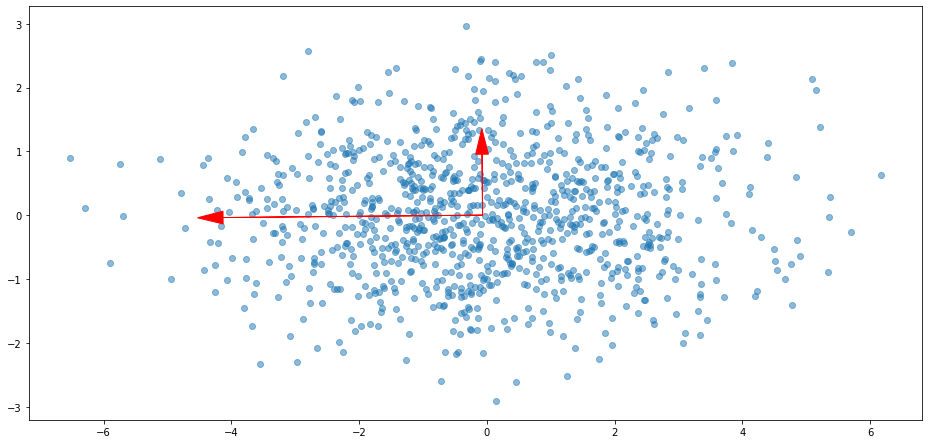

In [10]:
from sklearn.decomposition import PCA


def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)
    
    dec = PCA()
    dec.fit(dataset) # обучаем PCA
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]): # пробегаемся по выделенным компонентам (осям)
        component = dec.components_[comp_ind, :] # компонента
        var = dec.explained_variance_[comp_ind] # объясненная дисперсия
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')
    
    ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(16, 8))
PCA_show(data_synth_1)

Видим, что PCA все правильно нашел. Но это, конечно, можно было сделать и просто посчитав
дисперсию каждого признака. Повернем наши данные на некоторый фиксированный угол и проверим,
что для PCA это ничего не изменит.

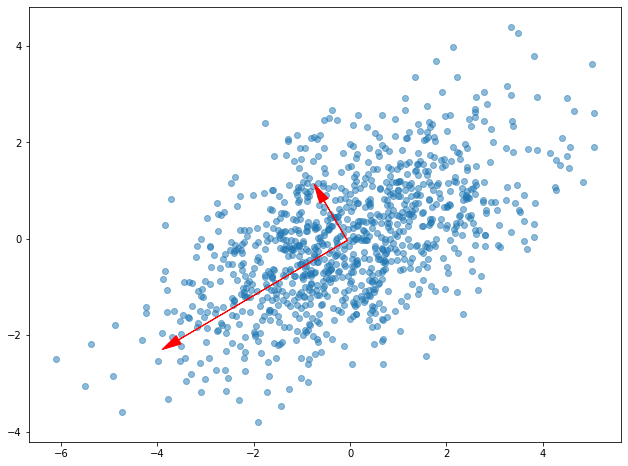

In [11]:
angle = np.pi / 6
rotate = np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
data_synth_2 = rotate.dot(data_synth_1.T).T

plt.figure(figsize=(16, 8))
PCA_show(data_synth_2)

Ну вот, все нормально. 

Ниже пара примеров, где PCA отработал не так хорошо (в том смысле, что направления задают не очень хорошие признаки).

**Упражнение.** Объясните, почему так произошло.

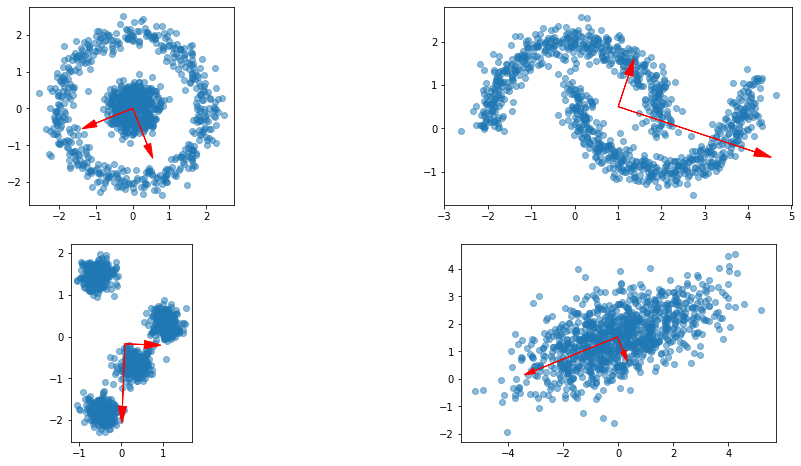

In [12]:
from sklearn.datasets import make_circles, make_moons, make_blobs

np.random.seed(54242)
data_synth_bad = [
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[0, 1.5], 
        cov=[[3, 1], 
             [1, 1]],
        size=1000),
]


plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

### Лица людей

Рассмотрим датасет с фотографиями лиц людей и применим к его признакам PCA.

Ниже изображены примеры лиц из базы, и последняя картинка &mdash; это "среднее лицо".

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\ASUS\scikit_learn_data


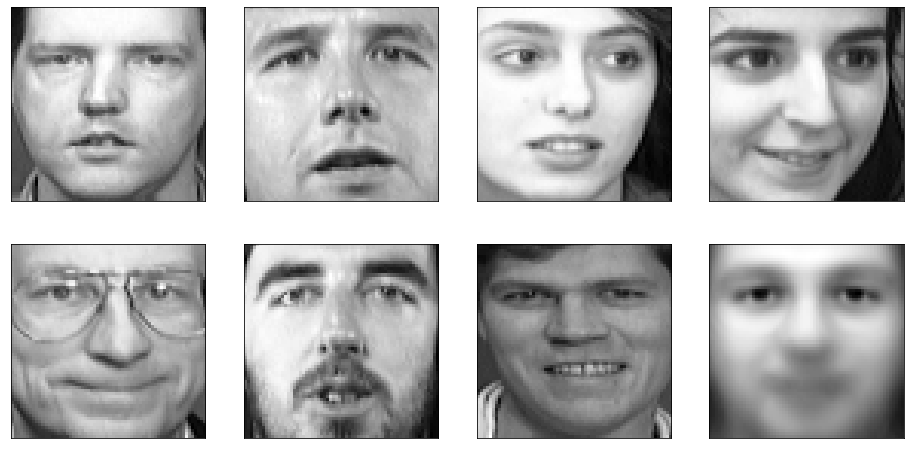

In [13]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=432542)
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)
    
mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)
plt.imshow(mean_face.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Теперь найдем главные компоненты

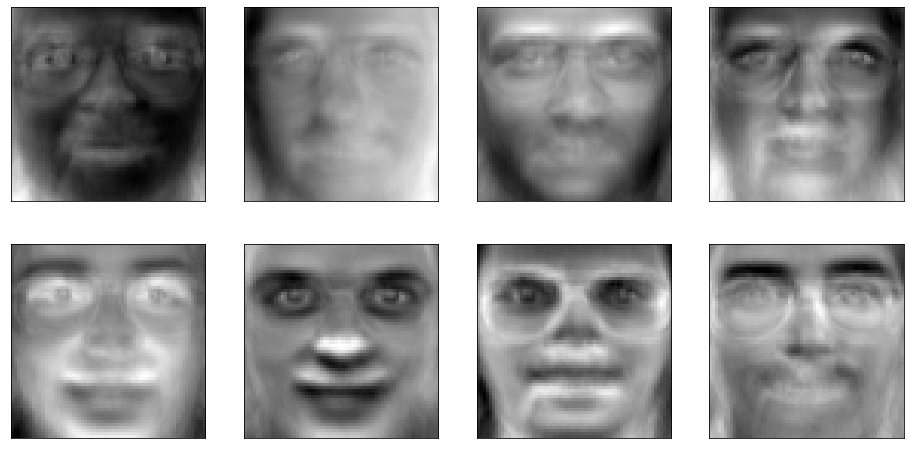

In [14]:
red = PCA()
faces_images -= mean_face
red.fit(faces_images)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(red.components_[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())

Получилось жутковато, что уже неплохо, но есть ли от этого какая-то польза?

Во-первых, новые признаки дают более высокое качество классификации.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gscv_rf = GridSearchCV(RandomForestClassifier(),
                       {'n_estimators': [100, 200, 500, 800], 'max_depth': [2, 3, 4, 5]},
                       cv=3)

In [16]:
%%time

gscv_rf.fit(faces_images, faces_ids)
print(gscv_rf.best_score_)

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.815
Wall time: 1min 28s


In [17]:
%%time

gscv_rf.fit(red.transform(faces_images)[:,:100], faces_ids)
print(gscv_rf.best_score_)

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.9
Wall time: 28.7 s


In [18]:
faces_images.shape

(400, 4096)

In [19]:
red.transform(faces_images).shape

(400, 400)

Во-вторых, их можно использовать для компактного хранения данных. Для этого объекты трансформируются
в новое пространство, и из него выкидываются самые незначимые признаки.

Ниже приведены результаты сжатия в 10 раз.

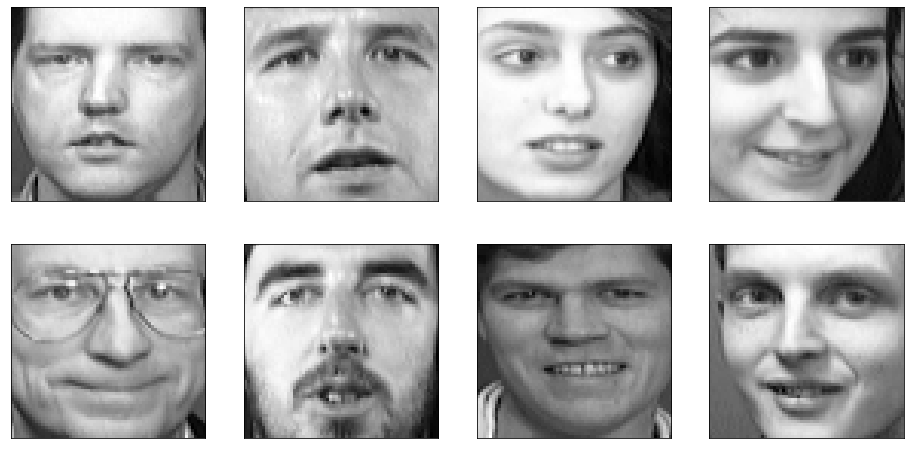

In [20]:
base_size = min(image_shape[0] * image_shape[1], faces_images.shape[0])

def compress_and_show(compress_ratio):
    red = PCA(n_components=int(base_size * compress_ratio))
    red.fit(faces_images)

    faces_compressed = red.transform(faces_images) # трансформируем данные с помощью PCA (проецируем точки на выделенные оси)
    faces_restored = red.inverse_transform(faces_compressed) + mean_face # обратное преобразование (восстанавливаем данные)

    plt.figure(figsize=(16, 8))
    rows, cols = 2, 4
    n_samples = rows * cols
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(faces_restored[i, :].reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())
        
compress_and_show(1)

И даже при сжатии в 20 раз лица остаются узнаваемыми.

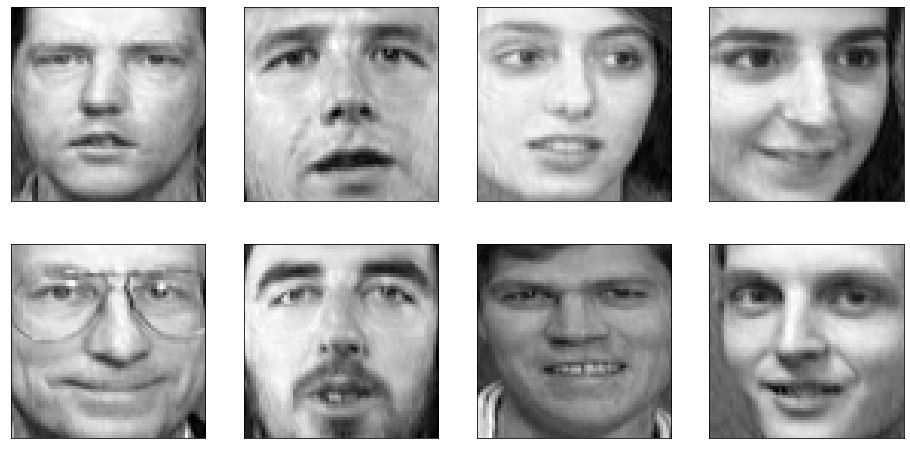

In [21]:
compress_and_show(0.5)

### PCA с ядрами

Так как PCA фактически работает не исходными признаками, а с матрицей их ковариаций, можно
использовать для ее вычисления вместо скалярного произведения $\langle x_i, x_j \rangle$ произвольное
ядро $K(x_i, x_j)$. Это будет соответствовать переходу в другое пространство, в котором
наше предположение о линейности уже будет иметь смысл. Единственная проблема &mdash; непонятно, как
подбирать ядро.

Ниже приведены примеры объектов в исходном пространстве (похожие группы обозначены одним цветом
для наглядности), и результат их трансформации в новые пространства (для разных ядер). Если результаты
получаются линейно разделимыми &mdash; значит мы выбрали подходящее ядро.

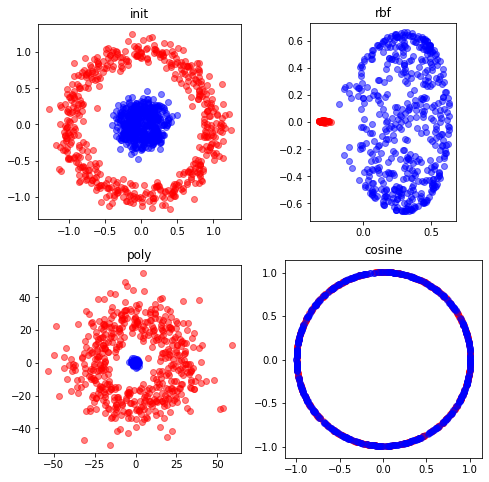

In [22]:
from sklearn.decomposition import KernelPCA


def KPCA_show(X, y):
    reds = y == 0
    blues = y == 1
    
    plt.figure(figsize=(8, 8))
    rows, cols = 2, 2
    plt.subplot(rows, cols, 1)
    plt.title('init')
    plt.scatter(X[reds, 0], X[reds, 1], alpha=0.5, c='r')
    plt.scatter(X[blues, 0], X[blues, 1], alpha=0.5, c='b')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    
    kernels_params = [
        dict(kernel='rbf', gamma=15),
        dict(kernel='poly', gamma=10),
        dict(kernel='cosine', gamma=10),
    ]
    
    for i, p in enumerate(kernels_params):
        dec = KernelPCA(**p)
        X_transformed = dec.fit_transform(X)
        
        plt.subplot(rows, cols, i + 2)
        plt.title(p['kernel'])
        plt.scatter(X_transformed[reds, 0], X_transformed[reds, 1], alpha=0.5, c='r')
        plt.scatter(X_transformed[blues, 0], X_transformed[blues, 1], alpha=0.5, c='b')
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        
np.random.seed(54242)
KPCA_show(*make_circles(n_samples=1000, factor=0.2, noise=0.1))

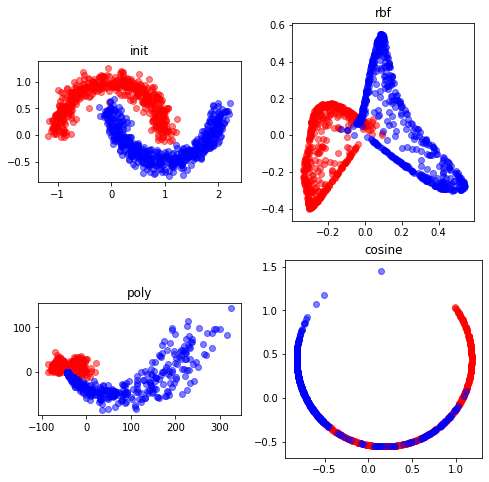

In [23]:
np.random.seed(54242)
KPCA_show(*make_moons(n_samples=1000, noise=0.1))

In [24]:
from mpl_toolkits import mplot3d

In [25]:
X, y = make_circles(n_samples=1000, factor=0.2, noise=0.1)

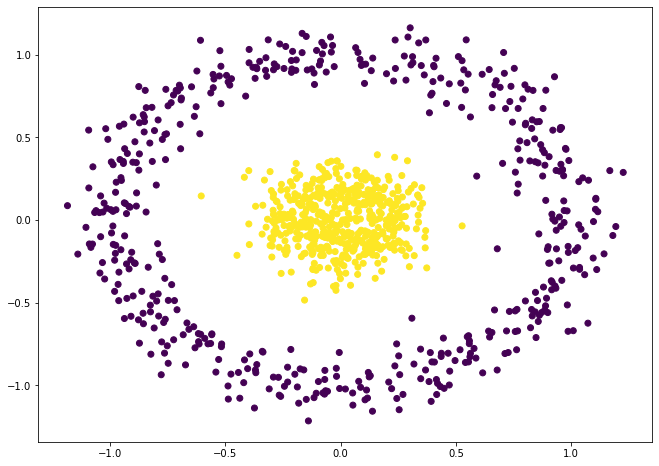

In [26]:
plt.scatter(X[:,0], X[:,1], c=y)

In [27]:
dec = KernelPCA(n_components=3, kernel='rbf', gamma=10)
new_X = dec.fit_transform(X)

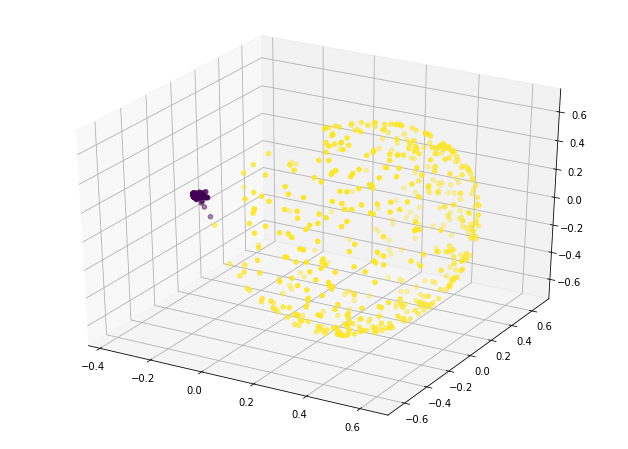

In [28]:
ax = plt.axes(projection='3d')

xdata = new_X[:,0]
ydata = new_X[:,1]
zdata = new_X[:,2]

ax.scatter3D(xdata, ydata, zdata, c=y);

In [29]:
from sklearn.manifold import TSNE

In [30]:
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(1000, 2)

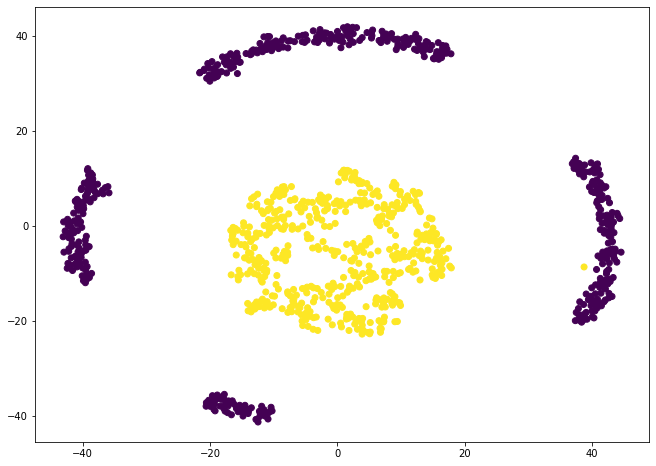

In [31]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)

# Визуализация с помощью t-SNE

In [32]:
from sklearn.datasets import load_digits
digits = load_digits()

In [33]:
X = digits["data"]
y = digits["target"]

In [34]:
X.shape

(1797, 64)

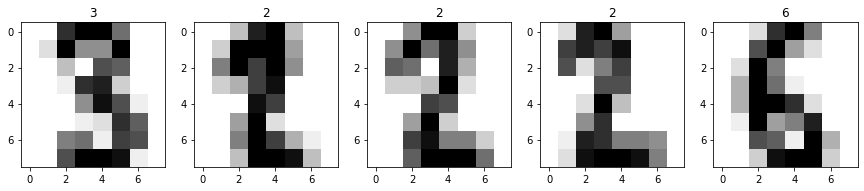

In [35]:
random_idx = np.random.choice(len(X), size=5)
random_digits = X[random_idx, :].reshape(-1, 8, 8)
random_labels = y[random_idx]
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i, d in enumerate(random_digits):
    ax[i].imshow(d, cmap='gray_r')
    ax[i].set_title(random_labels[i])

In [36]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

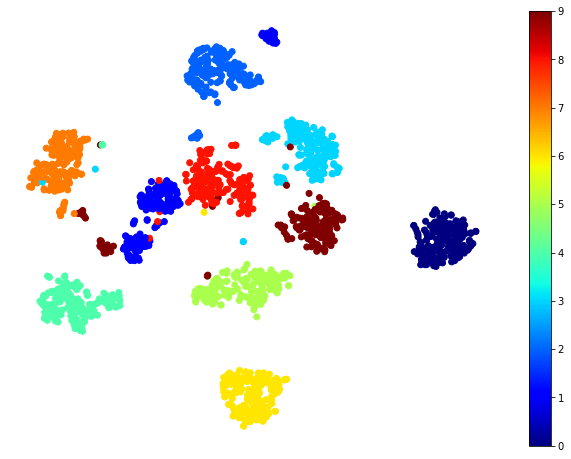

In [37]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

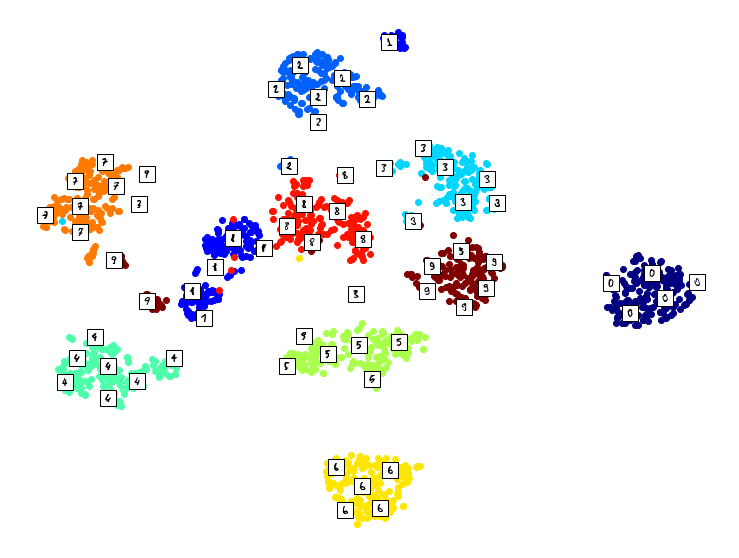

In [38]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(8, 8)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)
                
plot_digits(X_reduced, y, images=X)